In [1]:
import matplotlib
matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt

import matplotlib.dates as md
import datetime as dt
import time
import numpy as np
import pandas as pd
import pandas_ta as ta
from pandas import DataFrame
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as kl
from typing import List, Tuple
from ManualInterrupter import ManualInterrupter




In [2]:
def dateparse (time_in_secs):
    return dt.datetime.fromtimestamp(float(time_in_secs))

# Time, Open, High, Low, Closing, Volume, Trades

data = pd.read_csv('./../input/btc_usd_1min.csv',
                                 delimiter=',',
                                 names=["time", "open", "high", "low", "close", "volume", "trades"],
                                 parse_dates=True,
                                 date_parser=dateparse,
                                 index_col='time', )


#==============================
data = data.join(data.ta.rsi(length=14))
data = data.join(data.ta.rsi(length=14*60))
data = data.join(data.ta.rsi(length=24*60*14))

data["macd-1-days"] = data["close"].rolling(window = 60*24).mean()
data["macd-2-days"] = data["close"].rolling(window = round(26*60*24/12)).mean()

data["macd-12-hours"] = data["close"].rolling(window = 60*12).mean()
data["macd-26-hours"] = data["close"].rolling(window = 60*26).mean()

data["macd-15x15min"] = data["close"].rolling(window = 15*15).mean()
data["macd-26x15min"] = data["close"].rolling(window = 26*15).mean()

data["macd-1-hours"] = data["close"].rolling(window = 60).mean()
data["macd-2-hours"] = data["close"].rolling(window = round(60*26/12)).mean()

data["min-3-hours"] = data["close"].rolling(window = 180).min()
data["max-3-hours"] = data["close"].rolling(window = 180).max()

std_20 = data["close"].rolling(window = 20*60*24).std()
data["mean_bol"] = data["close"].rolling(window = 20*60*24).mean()
data["bol_down"] = data["mean_bol"] - 2 * std_20
data["bol_up"] = data["mean_bol"] + 2 * std_20

In [ ]:
#fig = plt.figure()
data["close"].plot()
#plt.plot([1,2,3,4,5,3,32],[7,6,5,4,3,2,1])

plt.show()

In [ ]:
#=========================================

prediction_time = 240 # 4h

data = data.dropna()
data_np: np.ndarray = data.to_numpy()

ml_past_preriod_per_features = 258
ml_indices: List[pd.Timestamp] = []
ml_inputs = np.empty([500000, ml_past_preriod_per_features, data.shape[1]])
ml_inputs_norm = np.empty([500000, ml_past_preriod_per_features, data.shape[1]])
ml_outputs = np.empty([500000])
ml_outputs_norm = []
ml_normalization: List[Tuple] = []

past_data_internal = 60 * 24 * 7
idx = past_data_internal

# for the first hour, we keep all
elementCount = 0

while idx < len(data) - prediction_time:
    # Take all data from the last hour.
    currentWindowData: np.ndarray = data_np[np.arange(idx - 60, idx)]

    # From 1h to 1 day, take on every 10 min.
    w = data_np[np.arange(idx - 60*24, idx - 60, 10)]
    currentWindowData = np.append(currentWindowData, w, axis=0)

    # Then for a 'past_data_internal', we keep every 2h
    w = data_np[np.arange(idx - past_data_internal + 60*24, idx - 60*24, 120)]
    currentWindowData = np.append(currentWindowData, w, axis=0)

    # Normalization
    minData = currentWindowData.min(initial=100000000)
    maxData = currentWindowData.max(initial=-10000000)
    currentWindowData = currentWindowData

    ml_inputs[elementCount] = currentWindowData
    ml_inputs_norm[elementCount] = (currentWindowData - minData) / maxData

    max2H = data.iloc[np.arange(idx, idx + prediction_time)]['close'].max()

    ml_outputs[elementCount] = max2H
    ml_outputs_norm.append((max2H - minData) / maxData)
    ml_normalization.append((minData, maxData))

    ml_indices.append(data.index[idx])

    idx += 30
    elementCount += 1


ml_inputs_norm = ml_inputs_norm[:elementCount]
ml_inputs = ml_inputs[:elementCount]
ml_outputs = ml_outputs[:elementCount]
ml_indices = ml_indices[:elementCount]


In [6]:
#=========================================

record_count = len(ml_inputs_norm)
train_size = round(record_count * 0.7)
test_size = record_count - train_size

ml_inputs_train_norm = ml_inputs_norm[:train_size]
ml_inputs_test_norm = ml_inputs_norm[train_size:]

ml_inputs_train = ml_inputs[:train_size]
ml_inputs_test = ml_inputs[train_size:]

ml_outputs_norm_train = ml_outputs_norm[:train_size]
ml_outputs_norm_test = ml_outputs_norm[train_size:]

ml_outputs_train = ml_outputs[:train_size]
ml_outputs_test = ml_outputs[train_size:]

ml_normalization_train = ml_normalization[:train_size]
ml_normalization_test = ml_normalization[train_size:]

In [ ]:
## Model Loading
## ==============

model = tf.keras.models.load_model("./CryptoMLTraderTraider/input/m")


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 258, 20)]    0                                            
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 249, 128)     25728       input_7[0][0]                    
__________________________________________________________________________________________________
conv1d_19 (Conv1D)              (None, 219, 128)     102528      input_7[0][0]                    
__________________________________________________________________________________________________
conv1d_20 (Conv1D)              (None, 254, 128)     12928       input_7[0][0]                    
____________________________________________________________________________________________

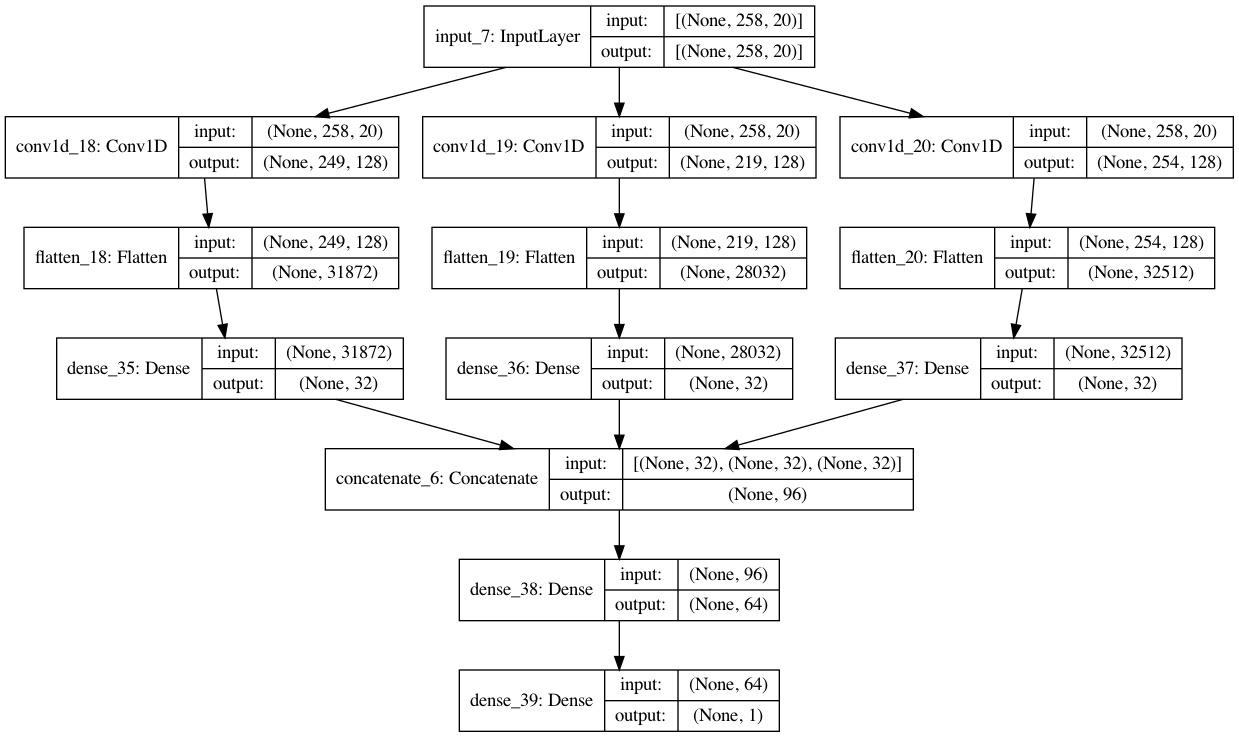

In [15]:
#=========================================

model_input = kl.Input(shape=(ml_past_preriod_per_features, data.shape[1],))
model_layer_1a = kl.Conv1D(filters=128, kernel_size=10)(model_input)
model_layer_2a = kl.Flatten()(model_layer_1a)
model_layer_3a = kl.Dense(32)(model_layer_2a)

model_layer_1b = kl.Conv1D(filters=128, kernel_size=40)(model_input)
model_layer_2b = kl.Flatten()(model_layer_1b)
model_layer_3b = kl.Dense(32)(model_layer_2b)

model_layer_1c = kl.Conv1D(filters=128, kernel_size=5)(model_input)
model_layer_2c = kl.Flatten()(model_layer_1c)
model_layer_3c = kl.Dense(32)(model_layer_2c)

# model_layer_1c = kl.Conv1D(filters=64, kernel_size=40)(model_input)
# model_layer_2c = kl.GlobalAveragePooling1D()(model_layer_1a)
# model_layer_3b = kl.Dense(32)(model_layer_2a)

model_layer_4 = kl.Concatenate()([model_layer_3a, model_layer_3b, model_layer_3c])

model_layer_5 = kl.Dense(64)(model_layer_4)

model_output = kl.Dense(1, activation=keras.activations.linear)(model_layer_5)

model: keras.Model = keras.Model(inputs=model_input, outputs=model_output)
model.summary()


model.compile(loss=keras.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam(learning_rate=0.00001), metrics=[keras.metrics.MeanSquaredError()])

tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [17]:
train_dataset_norm = tf.data.Dataset.from_tensor_slices((ml_inputs_train_norm, ml_outputs_norm_train)).shuffle(buffer_size=50).batch(64)
history = model.fit(train_dataset_norm, epochs=3, callbacks=[ManualInterrupter()])



Epoch 1/3
742/742 [==============================] - 81s 109ms/step - loss: 0.0046 - mean_squared_error: 0.0046

Predictions


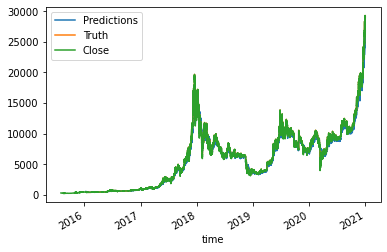

In [20]:
#=========================================
print("Predictions")

# normalized
idx = 0
all_dataset = tf.data.Dataset.from_tensor_slices((ml_inputs_norm)).batch(64)
all_predictions_norm = model.predict(all_dataset)
all_predictions = np.empty([len(all_predictions_norm)])

for prediction in all_predictions_norm:
    normalization_param = ml_normalization[idx]
    min = normalization_param[0]
    max = normalization_param[1]

    all_predictions[idx] = prediction * max + min
    idx += 1

#not normalized
# all_dataset = tf.data.Dataset.from_tensor_slices((ml_inputs)).batch(10)
# all_predictions = model.predict(all_dataset)

#Plotting

ml_indices_advanced = [idx + pd.Timedelta(minutes=prediction_time) for idx in ml_indices]


y_p_frame = DataFrame({
    "time": ml_indices_advanced,
    "predictions": all_predictions,
    "truth": ml_outputs
})
y_p_frame = y_p_frame.set_index("time")

data_with_pred = data.join(y_p_frame)

ax = data_with_pred["predictions"].dropna().plot()
data_with_pred["truth"].dropna().plot(ax=ax)
data_with_pred["close"].plot(ax=ax)
ax.legend(["Predictions", "Truth", "Close"])



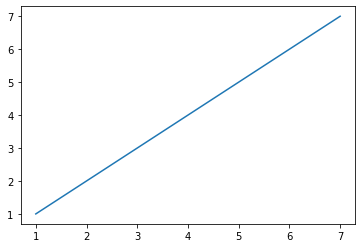

In [7]:
a = [1,2,3,4,5,6,7]
b = [1,2,3,4,5,6,7]

plt.plot(a,b)